## A ML-based Progress Coordinate for Enhanced Molecular Simulations
### ML Final Project : Darian Yang

My goal is to use machine learning to build a progress coordinate made of a linear combination of each of the calculated datasets from a weighted ensemble (WE) molecular dynamics (MD) simulation. Specifically, I will optimize the weight of each feature to maximize the ROCAUC score. Using these optimized weights, I can then: 1) predict the success probabilties of new simulation trajectories, 2) run further WE simulations using the weighted combination of calculated datasets, which should hopefully be able to more effectively capture successfull rare events compared to a native progress coordinate such as a distance metric.

#### Overall Workflow:
1. Data curation: run WE simulation(s).
2. Plot and analyze the WE simulation h5 dataset(s).
3. Build the input arrays for machine learning.
4. EDA on ml dataset to validate.
5. Run the gradient descent based weight optimization.
6. Compare with optimization of a completely randomized dataset.
7. Score this weight optimization based predictor on untrained data.
8. Compare with other models such as logistic regression and random forest.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
# WE data plotting package: https://pypi.org/project/wedap/0.0.5/
import wedap

In [6]:
# plot style
plt.style.use("/Users/darian/github/wedap/wedap/styles/default.mplstyle")

### 1: Data Curation

I started by running 2 WE simulations on the HIV-1 capsid protein to try to capture dimer dissociation events.

### 2: Plot and Analyze WE Simulations

Evolution: 100%|██████████| 500/500 [00:01<00:00, 453.67it/s]


Text(0.5, 1.0, 'Easy Classification Dataset')

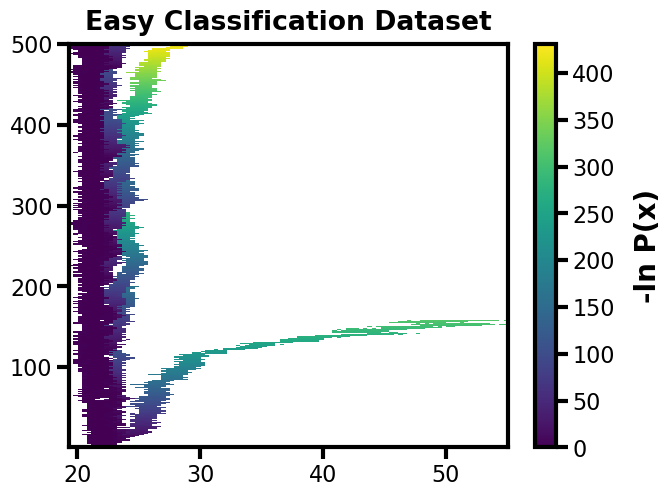

In [9]:
ecd = wedap.H5_Plot(h5="data/ctd_ub_1d_v00.h5", data_type="evolution")
ecd.plot()
ecd.ax.set_title("Easy Classification Dataset")


Evolution: 100%|██████████| 500/500 [00:01<00:00, 316.38it/s]


Text(0.5, 1.0, 'Hard Classification Dataset')

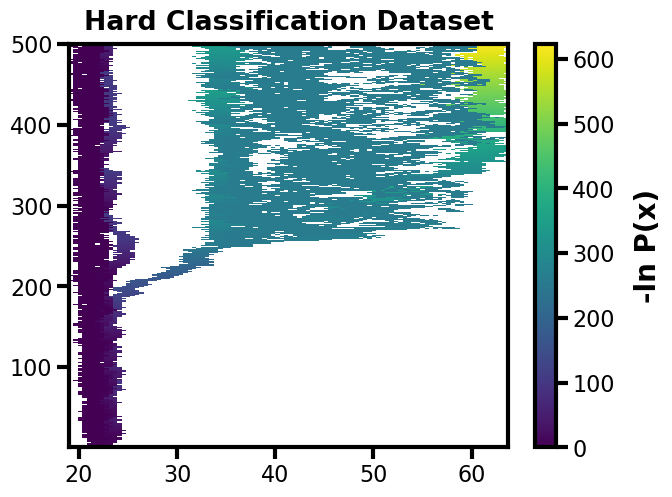

In [10]:
hcd = wedap.H5_Plot(h5="data/ctd_ub_1d_v04.h5", data_type="evolution")
hcd.plot()
hcd.ax.set_title("Hard Classification Dataset")

So these are two datasets of the same system but one of them provides an easy classification problem where the trajectories that break away are all labeled as successfull. The hard classification dataset has very specific conditions for being labeled as successfull and there is alot of trajectories that seem like they could be successfull but are not.

### 3: Building the ML Input Array

I coded the input array generation and ML helper functions in a separate script (`ml_pcoord.py`). See this script for more details, comments, and some preliminary explorations at the bottom.

I also tested a few different ways of generating and labeling the input and settled on this:
#### Original Dataset:
* ~18,000 simulation trajectories with 100 frames each
#### Processed Dataset:
* 50 Columns = Calculated 50 features
    * Various distances, angles, etc.
    * |last – first frame| at every iteration (then scaled by max value of each feature vector)
* 17912 Rows = each short trajectory (10 true)


In [1]:
from ml_pcoord import ML_Pcoord

First I will make all of the datasets for faster downstream analysis.

In [2]:
# for easy classification
ML_Pcoord(h5="data/ctd_ub_1d_v00.h5", savefile="ml_input_v00.tsv") 

# for hard classification
ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", savefile="ml_input_v04.tsv")

# without the pcoord_1 and min_dist datasets (which define the recycle boundary)
ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", skip_feats=["pcoord_1", "min_dist"], savefile="ml_input_cut.tsv")

Creating input array:   0%|          | 0/500 [00:00<?, ?it/s]

Creating input array:   0%|          | 0/500 [00:00<?, ?it/s]

Creating input array:   0%|          | 0/500 [00:00<?, ?it/s]

In [2]:
# random test dataset
ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", savefile="ml_input_rand.tsv", rand_ml_input=True)

### 4: EDA on the generated datasets

In [3]:
# find and output all successfull trajectories
ml = ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", gen_ml_input=False)
ml.w_succ()

[(292, 9),
 (316, 11),
 (402, 6),
 (425, 13),
 (436, 8),
 (459, 15),
 (459, 8),
 (466, 11),
 (467, 8),
 (470, 11)]

In [5]:
ml = ML_Pcoord(h5="data/ctd_ub_1d_v00.h5", gen_ml_input=False)
len(ml.w_succ())

61

In [4]:
# load dataset and count T/F labels
ml = ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", ml_input="X_ml_input_v04.tsv", seg_labels="y_ml_input_v04.tsv")
ml.count_tf()

TRUE: 10 | FALSE: 17902


In [3]:
ml = ML_Pcoord(h5="data/ctd_ub_1d_v00.h5", ml_input="X_ml_input_v00.tsv", seg_labels="y_ml_input_v00.tsv")
ml.count_tf()

TRUE: 61 | FALSE: 11899


### 5: Optimizing Weights

This is done using gradient descent in scipy, where the loss function is the ROCAUC score of the weighted average ml_input dataset in comparison to the actual T/F labels. The implementation is in the `ML_Pcoord.optimize_pcoord` method. The output is weights for each feature and the new progress coordinate would be a linear combination of weighted features.


--------------------------------------------
CYCLE: 0 | PRE LOSS: 0.574874315718914
--------------------------------------------
--------------------------------------------
CYCLE: 0 | POST LOSS: 0.878912970617808
--------------------------------------------
[('min_dist', 0.23722924144245014), ('pcoord_1', 0.2372292414424501), ('rms_h9m2_nmr', 0.09346276051631813), ('rms_h9m2_xtal', 0.08983428179907454), ('rms_key_int_xtal', 0.07744872955086027), ('rms_key_int_nmr', 0.06870497673589313), ('rms_m1_nmr', 0.053828764076622515), ('rms_m1_xtal', 0.049766240662796994), ('rms_h9m1_nmr', 0.049671194433511444), ('rms_h9m1_xtal', 0.042824569340021185)]


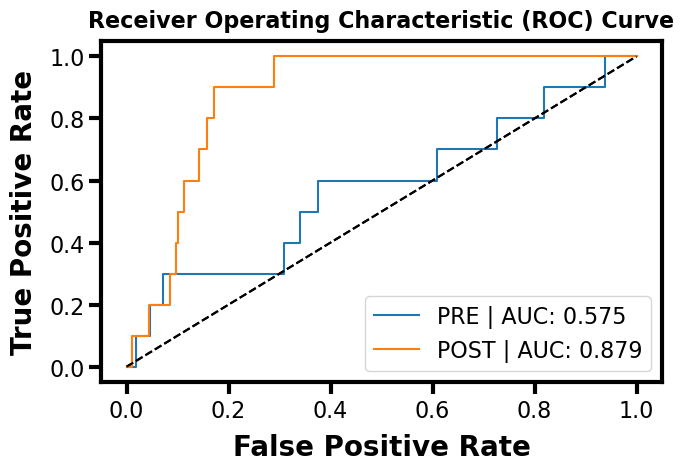

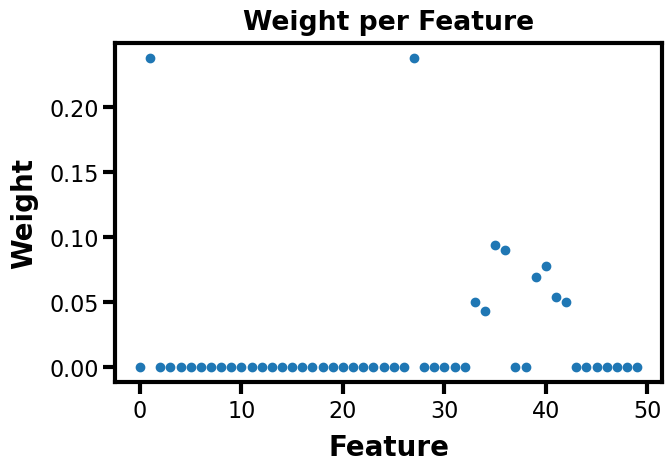

In [8]:
### rocauc plot and opt all feats ###
ml = ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", ml_input="X_ml_input_v04.tsv", seg_labels="y_ml_input_v04.tsv")
fw = ml.optimize_pcoord(plot=True, recycle=1)
top = ml.plot_weights()
print(top)
plt.show()

--------------------------------------------
CYCLE: 0 | PRE LOSS: 0.5371411015528991
--------------------------------------------
--------------------------------------------
CYCLE: 0 | POST LOSS: 0.842727069601162
--------------------------------------------
[('rms_key_int_xtal', 0.24503057930620611), ('rms_key_int_nmr', 0.22379708303092655), ('rms_h9m2_xtal', 0.1761878957847454), ('rms_h9m2_nmr', 0.1275167980732465), ('rms_h9m1_nmr', 0.09171399005671745), ('rms_h9m1_xtal', 0.06397292253096244), ('rms_heavy_nmr', 0.047228119700897415), ('rms_m1_xtal', 0.02419826721935193), ('rms_m1_nmr', 0.00035434429700459305), ('rms_184_185', 1.1490548160995212e-14)]


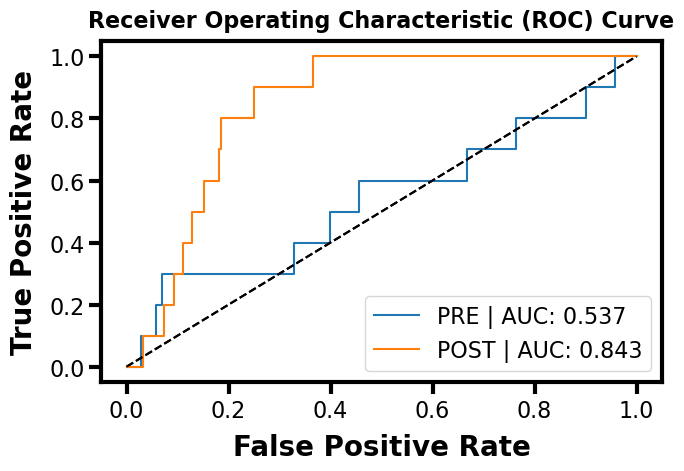

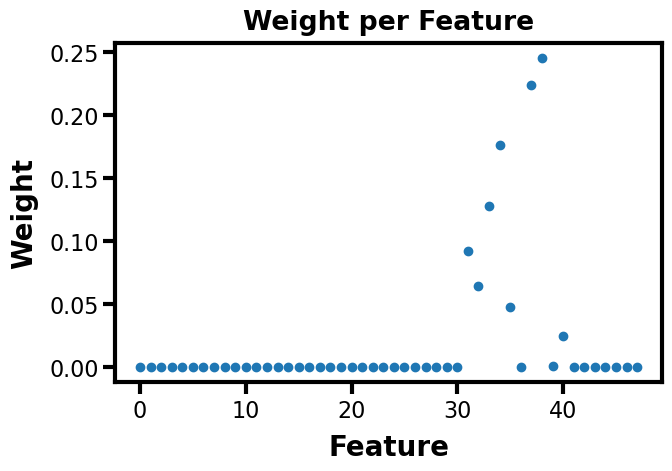

In [9]:
### rocauc plot and opt with skip_feats | also testing with and without std/norm ###
### from tests, going to go with no standardization and max vector based norm ###
ml = ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", ml_input="X_ml_input_cut.tsv", seg_labels="y_ml_input_cut.tsv", 
               skip_feats=["pcoord_1", "min_dist"])
fw = ml.optimize_pcoord(plot=True, recycle=1)
# seems like there are 6 non-near-zero features from the plot
top = ml.plot_weights(top_n=10)
print(top)
plt.show()

--------------------------------------------
CYCLE: 0 | PRE LOSS: 0.9464399129834578
--------------------------------------------
--------------------------------------------
CYCLE: 0 | POST LOSS: 0.998966713003848
--------------------------------------------
[('pcoord_1', 0.5336031726576654), ('rms_key', 0.3197182562960267), ('rms_key_int_xtal', 0.07431825832802072), ('rms_key_int_nmr', 0.07235982856191554), ('M1M2_COM', 4.841563713970796e-07), ('M2_E175_psi', 1.961232473012049e-16), ('secondary_struct', 8.654127026547583e-17), ('1_75_39_c2', 5.65116309609401e-17), ('M1_E175_chi3', 5.362759996981218e-17), ('intra_nnc', 5.3281567183358784e-17)]


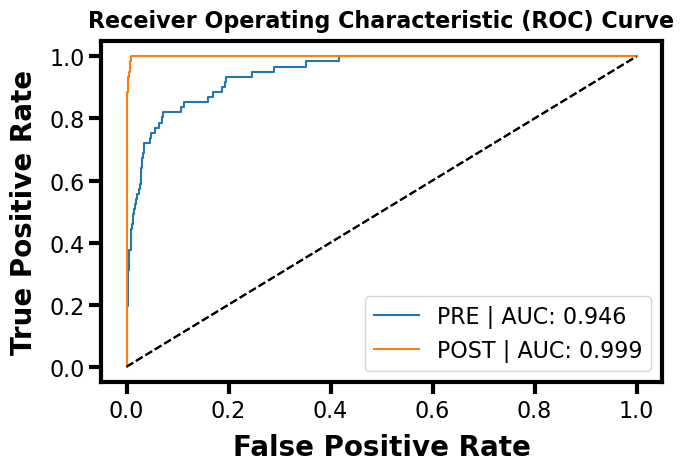

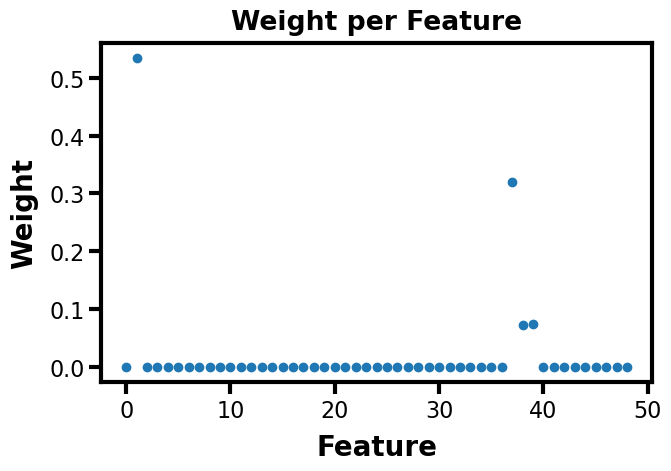

In [10]:
ml = ML_Pcoord(h5="data/ctd_ub_1d_v00.h5", ml_input="X_ml_input_v00.tsv", seg_labels="y_ml_input_v00.tsv")
fw = ml.optimize_pcoord(plot=True, recycle=1)
top = ml.plot_weights()
print(top)
plt.show()

It seems like this method can identify what I expect to be the best progress coordinate.

### 6: Compare to a Randomized Dataset

Here, I try to optimize a randomized dataset, which I expect to not change very much in terms of ROCAUC. This confirms that my methodolgy isn't just over optimizing anything that you throw at it, and that it is specifically able to target my domain problem.

--------------------------------------------
CYCLE: 0 | PRE LOSS: 0.503963287042144
--------------------------------------------
--------------------------------------------
CYCLE: 0 | POST LOSS: 0.5260288575719596
--------------------------------------------
[('pcoord_1', 0.13701276820407657), ('total_sasa', 0.11927321074160499), ('M1E175_M1T148', 0.07955776375314581), ('M1E175_M2W184', 0.07206403846505333), ('rms_key_int_xtal', 0.06292831398175995), ('rms_bb_xtal', 0.05756146852120075), ('1_75_39_c2', 0.04353380091717567), ('rog_cut', 0.04175785758125112), ('M2_E175_chi3', 0.04144239863643139), ('m1_sasa_mdt', 0.04033943558766287)]


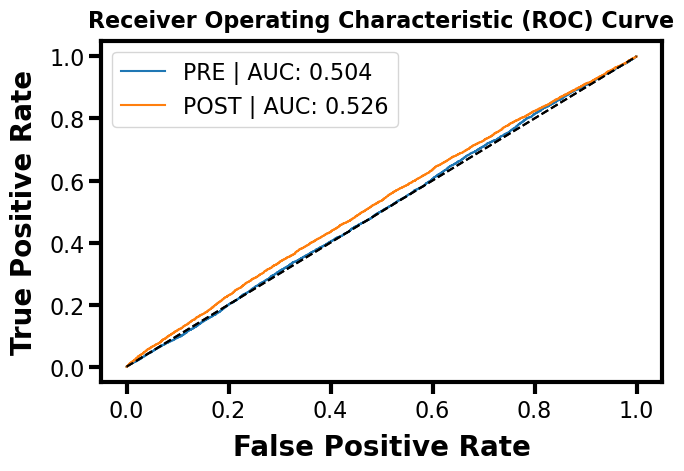

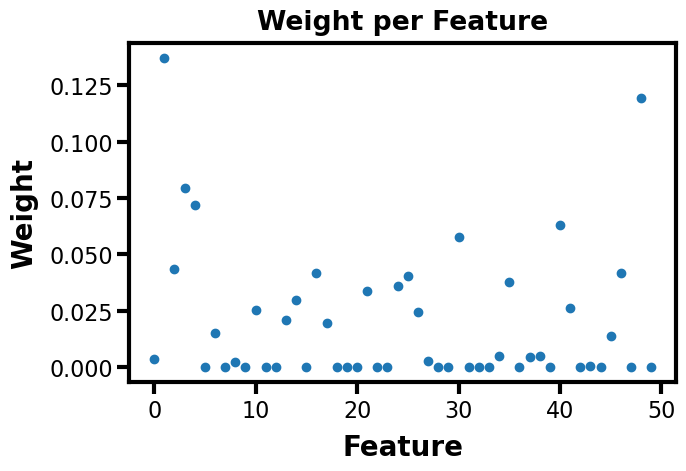

In [11]:
### random dataset ###
ml = ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", ml_input="X_ml_input_rand.tsv", seg_labels="y_ml_input_rand.tsv")
fw = ml.optimize_pcoord(plot=True, recycle=1)
top = ml.plot_weights(top_n=10)
print(top)
plt.show()

The random is as expected, no strong improvements upon optimization.

### 7: Split Dataset and Validate

Now I need to validate by splitting into test and train datasets, this is taken care of in the `ML_Pcoord.split_score` method.

--------------------------------------------
CYCLE: 0 | PRE LOSS: 0.6477653631284916
--------------------------------------------
--------------------------------------------
CYCLE: 0 | POST LOSS: 0.9502793296089386
--------------------------------------------
[('rms_h9m2_nmr', 0.2010689409103504), ('rms_h9m2_xtal', 0.16505771461145696), ('rms_m1_xtal', 0.16472185803415865), ('rms_m1_nmr', 0.14906552088611807), ('M1_E175_psi', 0.10117209648626703), ('rms_key_int_nmr', 0.06845270045854096), ('rms_key_int_xtal', 0.06419270970671084), ('M1E175_M1T148', 0.044254138573877), ('rms_184_185', 0.025409824761960544), ('M2_E175_chi3', 0.016604495570557955)]
0.8007697947214076


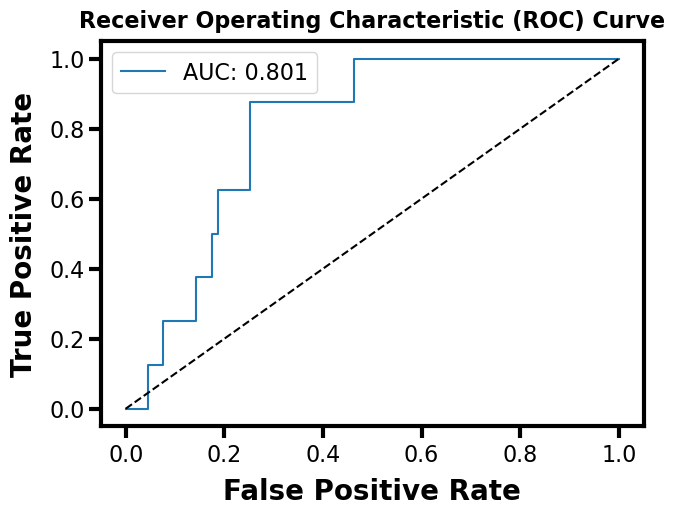

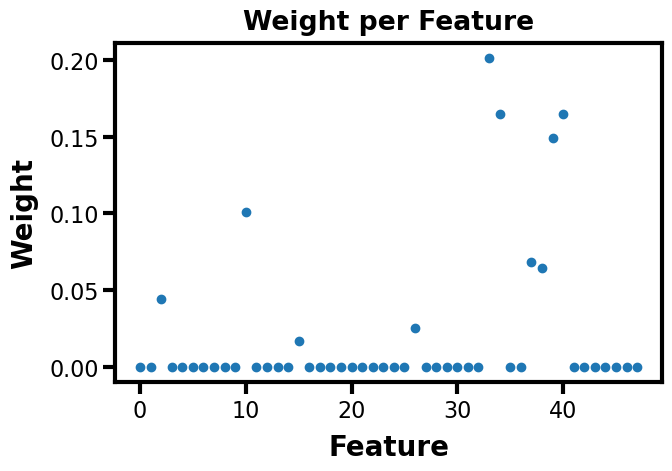

In [13]:
ml = ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", ml_input="X_ml_input_cut.tsv", seg_labels="y_ml_input_cut.tsv", 
               skip_feats=["pcoord_1", "min_dist"])

score = ml.split_score(score="auc")
print(ml.plot_weights())
print(score)

plt.show()

--------------------------------------------
CYCLE: 0 | PRE LOSS: 0.9342086834733894
--------------------------------------------
--------------------------------------------
CYCLE: 0 | POST LOSS: 0.9985294117647059
--------------------------------------------
[('pcoord_1', 0.2967482148849037), ('rms_key', 0.2084272790114804), ('rms_key_int_nmr', 0.18212163576299184), ('rms_key_int_xtal', 0.18095664845451528), ('M2_E175_psi', 0.13174622188610893), ('M1_E175_chi3', 1.4826326243520885e-16), ('m1_sasa_mdt', 1.1844891170344872e-16), ('rms_dimer_int_nmr', 1.1781532460633071e-16), ('intra_nc', 9.458565972837201e-17), ('M2E175_M2T148', 8.077216942628418e-17)]
0.9976438101241126


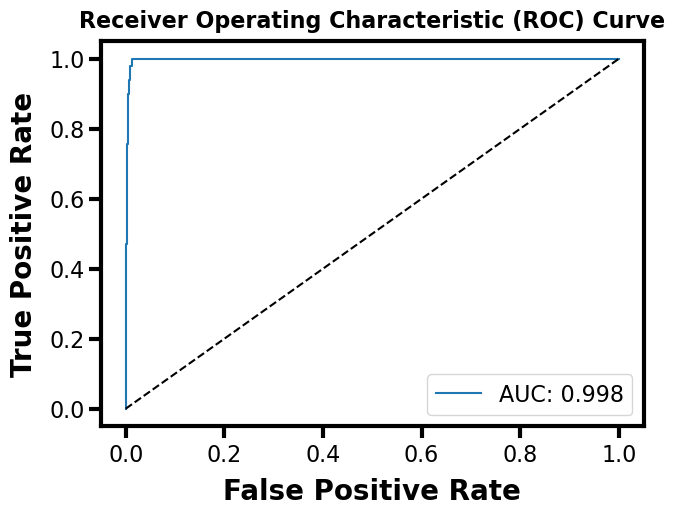

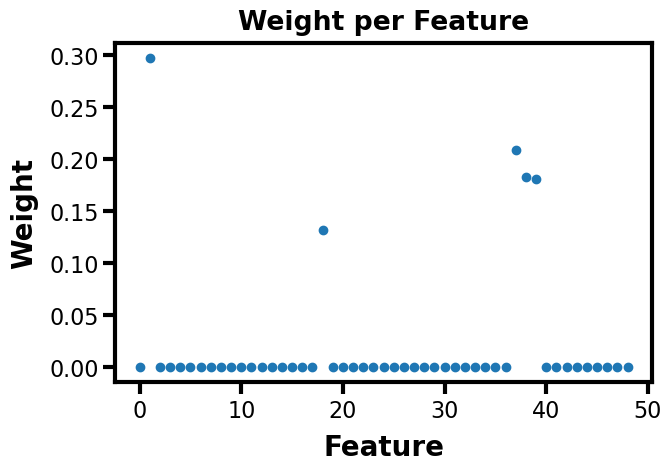

In [14]:
# trying with v00 instead since it had proper recycling
ml = ML_Pcoord(h5="data/ctd_ub_1d_v00.h5", ml_input="X_ml_input_v00.tsv", seg_labels="y_ml_input_v00.tsv")

score = ml.split_score(score="auc")
print(ml.plot_weights())
print(score)

plt.show()

So it doesn't score as well as with the test set as the traing, which is as expected, but overall, not bad.

### 8: Compare to Other ML Models

In [15]:
from sklearn import linear_model
from sklearn import ensemble

Confusion Matrix (tn, fp, fn, tp):
[14322     0     8     0]


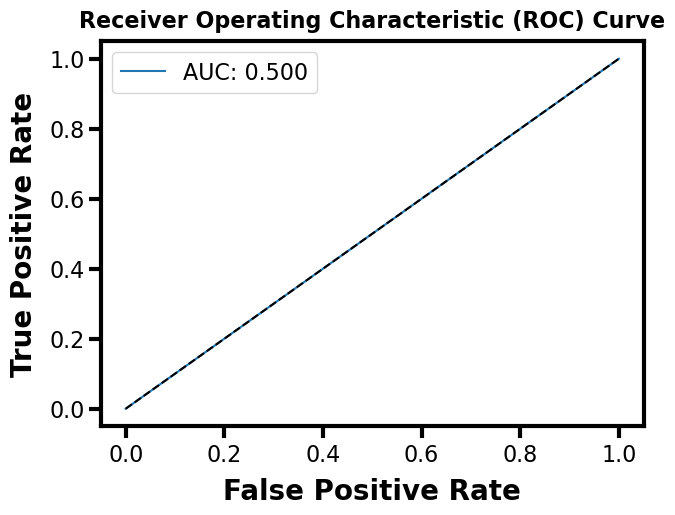

In [16]:
ml = ML_Pcoord(h5="data/ctd_ub_1d_v04.h5", ml_input="X_ml_input_cut.tsv", seg_labels="y_ml_input_cut.tsv", 
               skip_feats=["pcoord_1", "min_dist"])

ml.split_score(linear_model.LogisticRegression(), score="auc", confusion=True, opt_weights=False)
plt.show()

Confusion Matrix (tn, fp, fn, tp):
[14322     0     8     0]
OOB: 0.9994416527079844
[('angle_3pt', 0.08058320751744034), ('m1_sasa_mdt', 0.07967373691423348), ('rms_m2_xtal', 0.053336555601068446), ('M2E175_M1W184', 0.04951557294127585), ('rms_h9m2_nmr', 0.04927266829285472), ('M1_E175_phi', 0.04616323291894592), ('rms_m1_nmr', 0.04421613253582932), ('rms_key_int_nmr', 0.03959625034026411), ('intra_nc', 0.03902747612230508), ('rms_h9m1_xtal', 0.03694333352002649)]
0.5


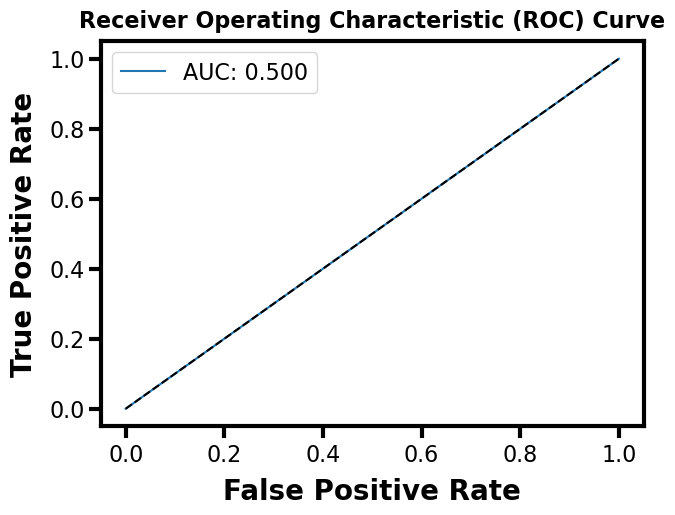

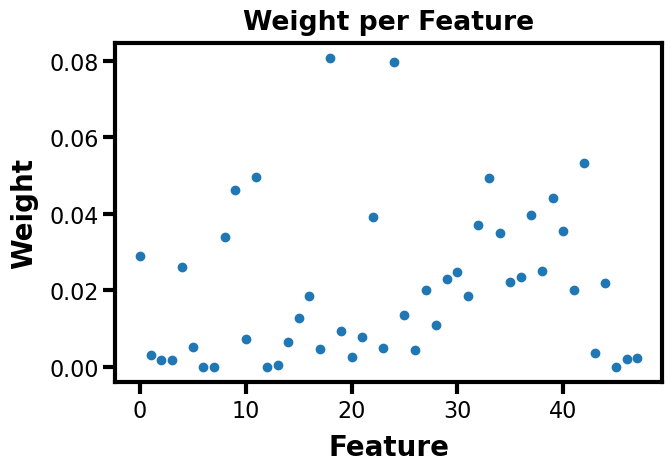

In [17]:
score = ml.split_score(ensemble.RandomForestClassifier(oob_score=True), score="auc", confusion=True, opt_weights=False)
print(f"OOB: {ml.model.oob_score_}")
print(ml.plot_weights(weights=ml.model.feature_importances_))
print(score)
plt.show()

Confusion Matrix (tn, fp, fn, tp):
[9511    8   39   10]


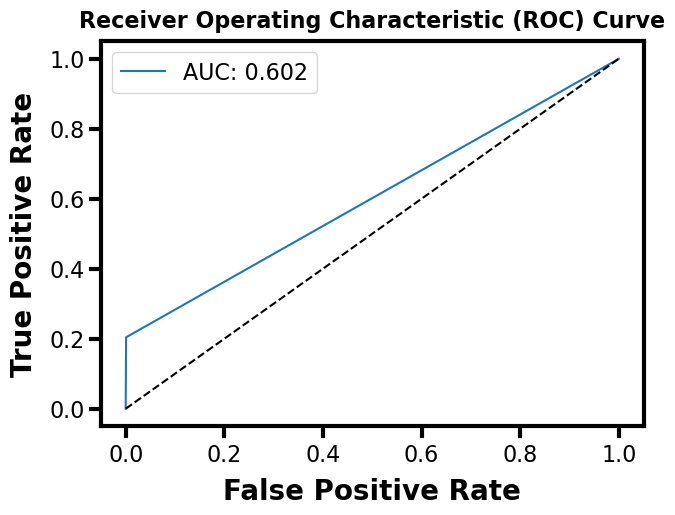

In [19]:
ml = ML_Pcoord(h5="data/ctd_ub_1d_v00.h5", ml_input="X_ml_input_v00.tsv", seg_labels="y_ml_input_v00.tsv")

ml.split_score(linear_model.LogisticRegression(), score="auc", confusion=True, opt_weights=False)
plt.show()

Confusion Matrix (tn, fp, fn, tp):
[9517    2   29   20]
OOB: 0.995819397993311
[('pcoord_1', 0.29132633688305554), ('rms_key', 0.04697052341385327), ('rog_cut', 0.04539324232432666), ('rog', 0.04014784814658059), ('rms_dimer_int_nmr', 0.039873216196626315), ('M1M2_COM', 0.039531179701429456), ('1_75_39_c2', 0.026902559450744372), ('rms_dimer_int_xtal', 0.0265116934469907), ('rms_h9m2_xtal', 0.02284469459338598), ('rms_h9m2_nmr', 0.02183045001547815)]
0.70397657960127


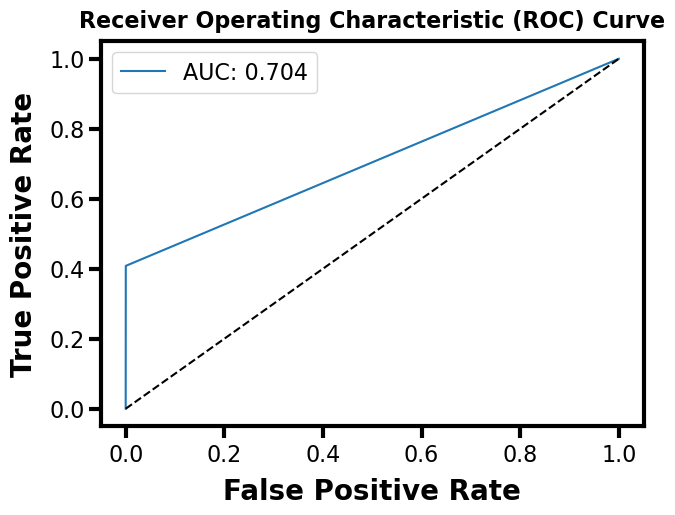

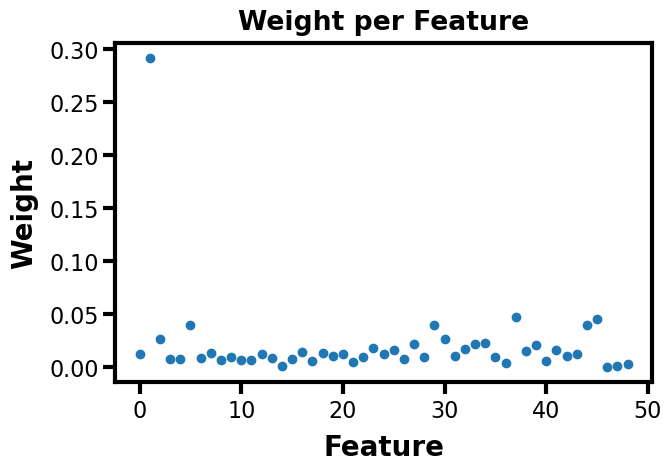

In [20]:

score = ml.split_score(ensemble.RandomForestClassifier(oob_score=True), score="auc", confusion=True, opt_weights=False)
print(f"OOB: {ml.model.oob_score_}")
print(ml.plot_weights(weights=ml.model.feature_importances_))
print(score)
plt.show()

It seems like RF is better than logistic, and RF feature importance also can identify what I would think is the best progress coordinate.

### Overall:
The best method upon comparison seems to be the weight optimization based predictor. 

For the "hard" classification dataset (ROCAUC scores on test data):
* Weight Opt: 0.801
* Logistic: 0.500
* RF: 0.500

For the "easy" classification dataset (ROCAUC scores on test data):
* Weight Opt: 0.998
* Logistic: 0.602
* RF: 0.704

It seems like for the hard dataset, other classifiers found it very difficult to accurately predict the successfull trajectories. For the easy dataset, the other ML models could perform better, but not as well as the weight optimization based predictor. However; I did not optimize the hyperparameters for logistic or RF models and there are other models that I didn't attempt. I did not report it on this notebook, but I also tried running RF using the optimized, weighted dataset. This seemed to allow for a minor improvement in ROCAUC score, especially for the easy dataset classification. Also not shown here is that I tried other scoring metrics instead of ROCAUC, such as f1-score, balanced accuracy score, and accuracy score (see `ML_Pcoord.split_score`). These results were in a similar theme to ROCAUC scoring.

Some future directions:
* Do some CV of the weight based and other ML models.
* I could optimize the RF model further by using RandomSearchCV.
* I can try adjusting the amount of True labels and conditions.
* Also could test different small and large changes to the optimization loss function.
* Finally, I need to run a follow up WE simulation using the combination coordinate to see if it actually leads to better results.